# Testing H-MDS Implementation

# Python/Numpy Implementation

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
import time
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [ ]:
def generate_data(n):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, 0.7, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return init_data

In [104]:
from sklearn.metrics import euclidean_distances

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def conjugate(z):
    z_bar = np.array([z[0], -z[1]])
    return z_bar

def poincare_dist(u, v, eps=1e-6):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

def partial_d(theta, x):
    alpha = 1 - norm(theta)**2
    beta = 1 - norm(x)**2
    gamma = 1 + 2/(alpha*beta + eps) * norm(theta-x)**2
    lhs = 4 / (beta*np.sqrt(gamma**2 - 1) + eps)
    rhs = 1/(alpha**2 + eps) * (norm(x)**2 - 2*np.inner(theta,x) + 1) * theta - x/(alpha + eps)
    return lhs*rhs

In [283]:
def step_error(r, Z, g, dissimilarities, n):
        M_r = np.zeros((n, 2))
        for j in range(n):
            M_r[j] = (-r*g[j] + Z[j]) / (-r*g[j] * conjugate(Z[j]) + 1)
            #print(M_r[j])
        return loss_fn(M_r, dissimilarities, n)

def line_search(Z, dissimilarities, g, n, r0, rmax):
    Z_norm = norm(Z, axis=1)**2
    M_prime = g*Z_norm.reshape(-1,1)
    qprime_0 = np.dot(M_prime[:,0].T, g[:,0]) + np.dot(M_prime[:,1].T, g[:,1])
    p = 0.9
    r = r0
    q0 = step_error(0, Z, g, dissimilarities, n)
    roof_fn = lambda r:q0 + p*qprime_0*r
    rmin = 1e-5
    while rmin < r < rmax and step_error(r, Z, g, dissimilarities, n) < roof_fn(r):
        #print(step_error(r, Z, g, dissimilarities, n))
        r = 2*r
    while r > rmax or step_error(r, Z, g, dissimilarities, n) > roof_fn(r):
        #print(step_error(r, Z, g, dissimilarities, n))
        if r < rmin:
            break
        r = r/2
    return r

In [300]:
class HyperMDS():
    
    def __init__(self, dim=2, max_iter=3, verbose=0, eps=1e-3, alpha=1,
                 random_state=None, dissimilarity="euclidean"):
        self.dim = dim
        self.dissimilarity = dissimilarity
        self.max_iter = max_iter
        self.alpha = alpha
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state
        
    def init_embed(self, low=-0.3, high=0.3):
        rand_init = np.random.uniform(low, high, size=(self.n, self.dim))
        self.embedding = rand_init
    
    def loss_fn(self):
        loss = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                d_ij = poincare_dist(self.embedding[i], self.embedding[j])
                delta_ij = self.alpha*self.dissimilarity_matrix[i][j]
                loss += (d_ij - delta_ij)**2
        self.loss = loss

    def compute_gradients(self):
        gradients = np.zeros((self.n, 2))
        for i in range(n):
            grad_zi = 0
            for j in range(i+1, n):
                dd_ij = 2*poincare_dist(self.embedding[i], self.embedding[j])
                ddelta_ij = 2*self.alpha*self.dissimilarity_matrix[i][j]
                dd_loss = dd_ij - ddelta_ij
                dd_dist = partial_d(self.embedding[i], self.embedding[j])
                grad_zi += dd_loss * dd_dist
            gradients[i] = grad_zi
        self.gradients = gradients
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, init=None, max_epochs = 40):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix = euclidean_distances(X)
        self.n = self.dissimilarity_matrix.shape[0]
        
        self.init_embed()
        
        #error_tol =
        #min_grad = 
        #min_step = 
        smax = 1
        loss_time = 0
        grad_time = 0
        line_time = 0
        prev_loss = np.inf
        self.loss_fn()
        print('Inital loss: ', self.loss)
        for i in range(max_epochs):
            start = time.time()
            self.loss_fn()
            #if np.abs(self.loss - prev_loss)/self.loss < 0.001:
            #    print('loss decrease not sufficient')
            #    break
            #prev_loss = self.loss
            end = time.time()
            loss_time += end - start
            start = time.time()
            self.compute_gradients()
            end = time.time()
            grad_time += end - start
            rmax = 1/(norm(self.gradients, axis=1).max()+eps) * np.tanh(smax/2)
            start = time.time()
            r = line_search(self.embedding, self.dissimilarity_matrix, self.gradients,
                            self.n, 0.001, rmax)
            print(r)
            end = time.time()
            line_time += end - start
            for j in range(self.n):
                zi_num = -r*self.gradients[j] + self.embedding[j]
                zi_denom = -r*self.gradients[j] * conjugate(self.embedding[j]) + 1
                zi_prime = zi_num / zi_denom
                self.embedding[j] = zi_prime
            print('Epoch ' +str(i) + ' complete')
            print('Loss: ', self.loss)
        print('Loss time: ', loss_time)
        print('Gradient time: ', grad_time)
        print('Line search time: ', line_time)
        return self.embedding

In [301]:
data = generate_data(100)

In [302]:
hmds = HyperMDS()
emb = hmds.fit_transform(data, max_epochs=10)
hmds.loss

Inital loss:  1162.7648774135641
0.032
Epoch 0 complete
Loss:  1162.7648774135641
0.016
Epoch 1 complete
Loss:  1157.4890941964836
0.032
Epoch 2 complete
Loss:  1156.9987856414396
0.064
Epoch 3 complete
Loss:  1156.3531818828185
0.032
Epoch 4 complete
Loss:  1154.110239625411
0.032
Epoch 5 complete
Loss:  1148.9814689816144
0.032
Epoch 6 complete
Loss:  1146.8135251445863
0.016
Epoch 7 complete
Loss:  1145.2443158278995
0.001
Epoch 8 complete
Loss:  1144.928284006943
7.8125e-06
Epoch 9 complete
Loss:  1144.9312351621447
Loss time:  1.0044283866882324
Gradient time:  0.027965307235717773
Line search time:  9.042980194091797


1144.9312351621447

In [295]:
def sammon_stress(embedding, dissimilarity_matrix, alpha=1):
    stress = 0
    scale = 0
    n = embedding.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            d_ij = poincare_dist(embedding[i], embedding[j])
            delta_ij = alpha * dissimilarity_matrix[i][j]
            scale += delta_ij
            stress += ((d_ij - alpha*delta_ij) / alpha*delta_ij)**2
    scale=alpha*scale
    return stress/scale
sammon_stress(emb, hmds.dissimilarity_matrix)

22.229517101942232

In [289]:
from sklearn.datasets import load_iris
iris = load_iris()
data = iris['data']
data.shape

(150, 4)

In [296]:
hmds = HyperMDS(alpha=4)
iris_emb = hmds.fit_transform(data, max_epochs=20)
hmds.loss
sammon_stress(iris_emb, hmds.dissimilarity_matrix, alpha=4)

Inital loss:  1498066.3684449508
0.008
Epoch 0 complete
Loss:  1498066.3684449508
0.008
Epoch 1 complete
Loss:  1489329.852131235
3.125e-05
Epoch 2 complete
Loss:  1477006.099800636
1.5625e-05
Epoch 3 complete
Loss:  1477111.5192979933
1.5625e-05
Epoch 4 complete
Loss:  1477159.7787977192
1.5625e-05
Epoch 5 complete
Loss:  1477205.936787915
1.5625e-05
Epoch 6 complete
Loss:  1477250.1284380825
1.5625e-05
Epoch 7 complete
Loss:  1477292.476345776
1.5625e-05
Epoch 8 complete
Loss:  1477333.0920528965
1.5625e-05
Epoch 9 complete
Loss:  1477372.0773390275
3.125e-05
Epoch 10 complete
Loss:  1477409.525330292
6.25e-05
Epoch 11 complete
Loss:  1477481.2080377587
0.000125
Epoch 12 complete
Loss:  1477612.745796008
0.0005
Epoch 13 complete
Loss:  1477835.3728416637
0.008
Epoch 14 complete
Loss:  1478450.9201236144
0.004
Epoch 15 complete
Loss:  1478247.67149022
0.004
Epoch 16 complete
Loss:  1474514.997074454
7.8125e-06
Epoch 17 complete
Loss:  1472068.446371668
7.8125e-06
Epoch 18 complete
Los

1472064.5813715113

1090.8751043797115

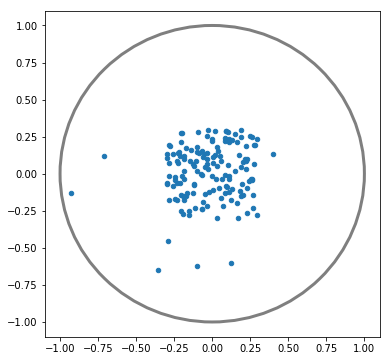

In [298]:
def plot_poincare(data, title=None):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    ax.scatter(data[:,0], data[:,1], s=20, alpha=1)
    if title != None: plt.title(title)
    plt.show()
init = np.random.uniform(-0.3, 0.3, size=(100, 2))
#plot_poincare(emb)
#plot_poincare(init)
plot_poincare(iris_emb)

In [ ]:
def poincare_dist(u, v, eps=1e-6):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

def poincare_dist2(u, v, eps=1e-6):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)


In [2]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()